### Importing Libraries

In [1]:
#!pip install Pillow
#!pip install image
#!pip install pytorch torchvision
#!pip install gdown

# Pillow is the Python Image Library.
import PIL
# Django Applictin that provides cropping, resizing, thumbnailing, overlays and masking for images and videos.
from PIL import Image
# Provides Tensor computation (like numpy) with GPU acceleration and Deep Neural Networks built on a tape-based autograd system.
import torch
# Provides common image transformations
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
# Downloading a large file from Google Drive
import gdown
import os
import time
import copy

### Training on GPU or CPU ?

In [2]:
# Check to see if CUDA is available.
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is not available. Training on CPU ...
cpu


### Download the Data

In [10]:
# output = '../breast_cancer_data_v1.zip'
output = '../BreaKHis_v1.tar'
# os.makedirs(output, exist_ok=True)

# Complete dataset ~4GB
# url = 'https://drive.google.com/uc?id=1k2RHhOLHYv2mTLk0GE0SajjfvpziEHJI'

# mini dataset (10 malignant and 10 benign PNGs)
# url = 'https://drive.google.com/uc?id=12L3PE1YI-XOXdyuLNIe7cHu-JaoqMpW3'
url ='https://drive.google.com/uc?id=1oqKkG-NjIuMuXNMSSwUyoDjNdlJo9fqP'

gdown.download(url, output, quiet=False)
# !tar zxvf {output}

In [11]:
os.system(f'tar -zxvf {output}')

512

In [4]:
# Organize the dataset
x = %pwd   # find current directory
data_home = x + '/cancer_data_v1'
train_dir = data_home + '/train'
valid_dir = data_home + '/valid'
num_workers = 4
batch_size = 32

### Transforms, Augmentation, and Normalization

In [5]:
# Define transforms, data augmentation, and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Load datasets with ImageFolder

In [6]:
# use ImageFolder to load the dataset
image_datasets = {x: datasets.ImageFolder(os.path.join(data_home, x), data_transforms[x])
                 for x in ['train', 'valid']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

### Building and training the classifier

#### Picking a pretrained model: Resnet-152
We decided to used the pre-trained Resnet-152 to extract features for classification. 

Resnet-152 is a type of specialized neural network that helps to handle more sophisticated deep learning tasks and models. Resnet introduces a structure called residual learning unit to alleviate the degradation of deep neural networks. The structure is a feedforward network with a shortcut connection which adds new inputs into the network and generates new outputs. The main merit of this unit is that it produces better classification accuracy without increasing the complexity of the model

In [7]:
# Build and train your network

# Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#Let's check the model architecture:
    print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\Craig/.cache\torch\checkpoints\resnet152-b121ed2d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 230M/230M [00:23<00:00, 10.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations

# Our input_size matches the in_features of pretrained model

from collections import OrderedDict

# Creating the classifier ordered dictionary first
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [11]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
# Train a model with a pre-trained network
num_epochs = 10
if train_on_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
#optimizer = optim.Adam(model.fc.parameters(), lr=0.005)
optimizer = optim.SGD(model.fc.parameters(), lr = .0006, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------


C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5749 Acc: 0.7104
valid Loss: 0.4733 Acc: 0.8291

Epoch 2/10
----------
train Loss: 0.4888 Acc: 0.7776
valid Loss: 0.3866 Acc: 0.8696

Epoch 3/10
----------
train Loss: 0.4423 Acc: 0.8082
valid Loss: 0.3439 Acc: 0.8845

Epoch 4/10
----------
train Loss: 0.4213 Acc: 0.8200
valid Loss: 0.3181 Acc: 0.8905

Epoch 5/10
----------
train Loss: 0.4044 Acc: 0.8350
valid Loss: 0.3146 Acc: 0.8899

Epoch 6/10
----------
train Loss: 0.3999 Acc: 0.8356
valid Loss: 0.3110 Acc: 0.8892

Epoch 7/10
----------
train Loss: 0.3958 Acc: 0.8376
valid Loss: 0.3065 Acc: 0.8932

Epoch 8/10
----------
train Loss: 0.3926 Acc: 0.8340
valid Loss: 0.3047 Acc: 0.8926

Epoch 9/10
----------
train Loss: 0.3939 Acc: 0.8396
valid Loss: 0.3028 Acc: 0.8905

Epoch 10/10
----------
train Loss: 0.3959 Acc: 0.8392
valid Loss: 0.3018 Acc: 0.8926

Training complete in 601m 57s
Best valid accuracy: 0.893243


In [24]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

test(model, dataloaders, device)

Testing Accuracy: 0.020
Testing Accuracy: 0.037
Testing Accuracy: 0.058
Testing Accuracy: 0.076
Testing Accuracy: 0.095
Testing Accuracy: 0.114
Testing Accuracy: 0.135
Testing Accuracy: 0.155
Testing Accuracy: 0.176
Testing Accuracy: 0.195
Testing Accuracy: 0.215
Testing Accuracy: 0.234
Testing Accuracy: 0.253
Testing Accuracy: 0.273
Testing Accuracy: 0.292
Testing Accuracy: 0.311
Testing Accuracy: 0.330
Testing Accuracy: 0.350
Testing Accuracy: 0.370
Testing Accuracy: 0.391
Testing Accuracy: 0.409
Testing Accuracy: 0.429
Testing Accuracy: 0.449
Testing Accuracy: 0.466
Testing Accuracy: 0.485
Testing Accuracy: 0.503
Testing Accuracy: 0.521
Testing Accuracy: 0.539
Testing Accuracy: 0.558
Testing Accuracy: 0.576
Testing Accuracy: 0.594
Testing Accuracy: 0.614
Testing Accuracy: 0.630
Testing Accuracy: 0.650
Testing Accuracy: 0.669
Testing Accuracy: 0.688
Testing Accuracy: 0.705
Testing Accuracy: 0.725
Testing Accuracy: 0.743
Testing Accuracy: 0.763
Testing Accuracy: 0.781
Testing Accuracy

In [28]:
# Save the checkpoint
fName = 'b_cancer_checkpoint_01.pth'

# Now that the network is trained,  we will save the model so we can load it later for making predictions.
# We will save the mapping of classes to indices which we get from one of the image
# datasets: `image_datasets['train'].class_to_idx`. We will attach this to the model as an attribute
# which makes inference easier later on.

model.class_to_idx = image_datasets['train'].class_to_idx

# Remember that we'll want to completely rebuild the model later so we can use it for inference. 
# Make sure to include any information you need in the checkpoint. If you want to load the model
# and keep training, you'll want to save the number of epochs as well as the optimizer state,
# `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project,
# so best to save it now.

# Save the checkpoint 
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, fName)

In [30]:
# Loading the checkpoint
# At this point it's good to write a function that can load a checkpoint and rebuild the model.
# That way you can come back to this project and keep working on it without having to retrain the network.

#Load the trained model from here:
url = 'https://drive.google.com/uc?id=1Mev8CsZEfQDAvMV6msKcaXHGC5BydizS'
gdown.download(url, output=None, quiet=False)

# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

Downloading...
From: https://drive.google.com/uc?id=1Mev8CsZEfQDAvMV6msKcaXHGC5BydizS
To: C:\Users\Craig\b_cancer_checkpoint_01.pth
242MB [00:10, 23.3MB/s] 


In [32]:
# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint(fName)
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [33]:
# Inference for classification
# Now you'll write a function to use a trained network for inference. 
# That is, you'll pass an image into the network and predict the class. 
# Write a function called `predict` that takes an image and a model, then returns
# the top $K$ most likely classes along with the probabilities. It should look like


def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [45]:
# Class Prediction

# Once you can get images in the correct format, it's time to write a function for making predictions
# with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes.
# You'll want to calculate the class probabilities then find the $K$ largest values.

# To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk).
# This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes.
# You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the
# model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the
# dictionary so you get a mapping from index to class as well.

# Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    
    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

img = 'cancer_data_v1/valid/malignant/SOB_M_DC-14-2980-400-005.png'

print (predict(img, loaded_model))

(array([0.7839791 , 0.21602088], dtype=float32), ['malignant', 'benign'])


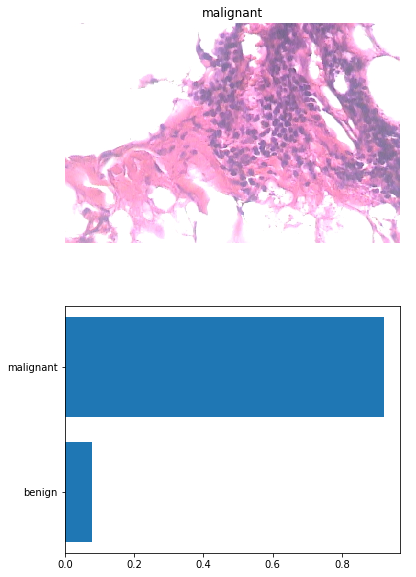

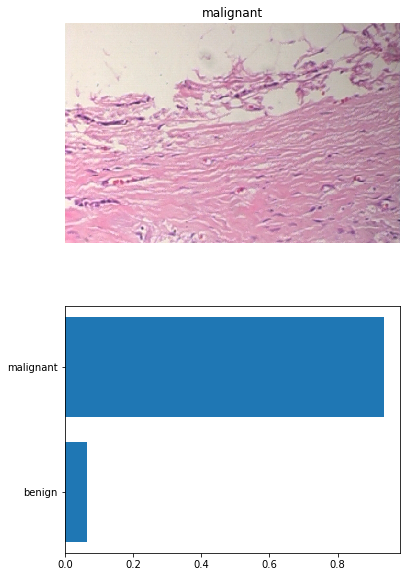

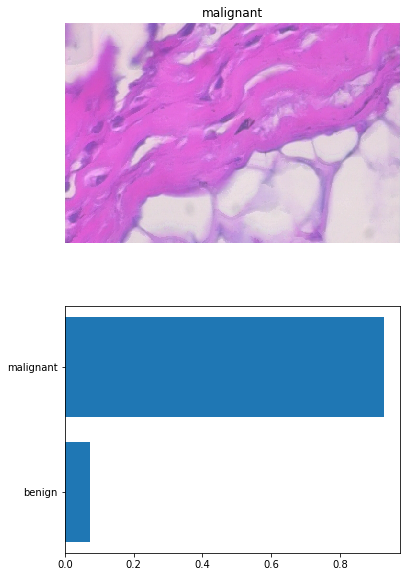

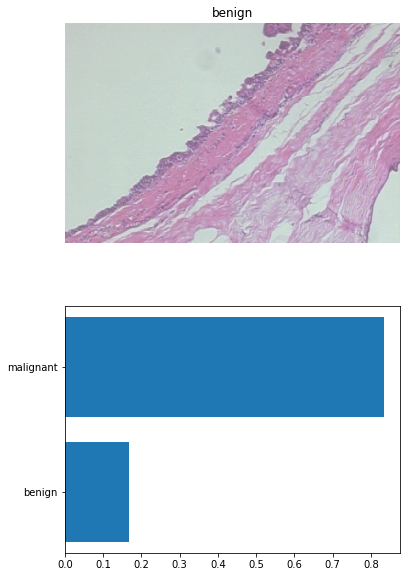

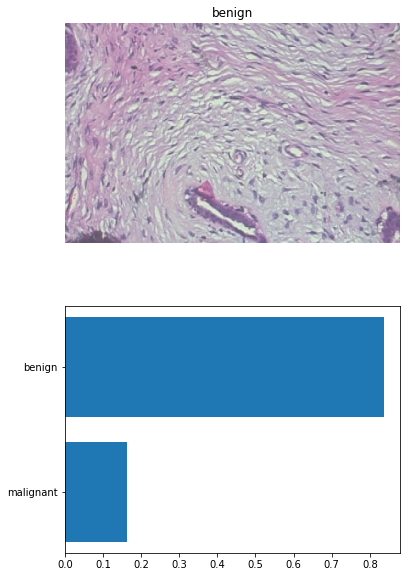

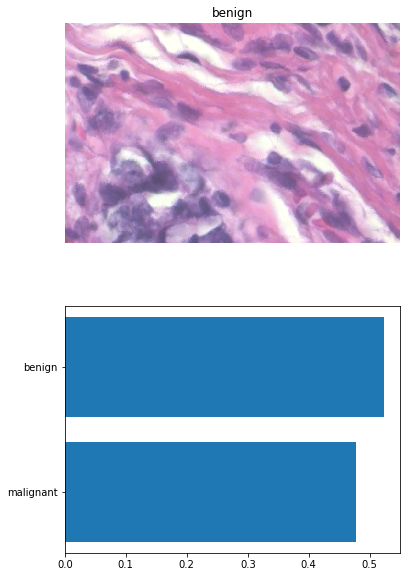

In [52]:
# Sanity Checking

# Now that you can use a trained model for predictions, check to make sure it makes sense.
# Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs.
# Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the
# input image. It should look like this:

cat_to_name = {"benign":"benign","malignant":"malignant"}

# Display an image along with the top 2 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    cancer_type = mapper[img_filename]
    
    ax1.set_title(cancer_type)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

# Predicting Malignant Images
img = 'cancer_data_v1/valid/malignant/SOB_M_PC-15-190EF-200-012.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

img = 'cancer_data_v1/valid/malignant/SOB_M_DC-14-13412-100-005.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

img = 'cancer_data_v1/valid/malignant/SOB_M_MC-14-18842-400-003.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

# Predicting Benign Images
img = 'cancer_data_v1/valid/benign/SOB_B_A-14-22549AB-40-021.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

img = 'cancer_data_v1/valid/benign/SOB_B_PT-14-22704-100-035.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

img = 'cancer_data_v1/valid/benign/SOB_B_TA-14-16184-400-017.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)